## Imports

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple, Optional
import matplotlib.pyplot as plt

import warnings
from pathlib import Path

---
<br>

## Configurações

In [4]:
# Filtrando os erros
warnings.filterwarnings('ignore')

# Caminhos para o diretório dos dados
data_path = Path('../01_dados')

---
<br>

### 1. Manipulação de Dados 

In [6]:
# Importando os dados
df = pd.read_csv(data_path / 'conjunto_vendas_exemplo_iso.csv', 
                 encoding='latin-1')

df.head(5)

,Região,Categoria,Produto,Vendas
0,Norte,Eletrônicos,TV,1500
1,Norte,Móveis,Sofá,1200
2,Sul,Eletrônicos,Celular,3000
3,Sul,Móveis,Mesa,2000
4,Leste,Eletrônicos,Notebook,2500


#### 1. Vendas totais por região e categoria.

In [8]:
# Agrupando por Região e Categoria e somando as vendas
vendas_totais = df.groupby(['Região', 'Categoria'])['Vendas'].sum().reset_index()

# Exibindo o resultado
print(vendas_totais)

  Região    Categoria  Vendas
0  Leste  Eletrônicos    2500
1  Leste       Móveis    1800
2  Norte  Eletrônicos    1500
3  Norte       Móveis    1200
4  Oeste  Eletrônicos    1000
5  Oeste       Móveis    1300
6    Sul  Eletrônicos    3000
7    Sul       Móveis    2000


---
<br>

#### 2. Produto com melhor desempenho de cada categoria.

In [10]:
# Identificando o produto de melhor desempenho em cada categoria
melhores_produtos = df.loc[df.groupby('Categoria')['Vendas'].idxmax()]

# Exibindo o resultado
print(melhores_produtos)

  Região    Categoria  Produto  Vendas
2    Sul  Eletrônicos  Celular    3000
3    Sul       Móveis     Mesa    2000


### 2. Implementação de Algoritmo K-means

Para executar um agrupamento k-means:

1. Especifique o número de clusters que você deseja (geralmente referido como `k`).
2. Inicialize aleatoriamente o `centroide` para cada cluster. O centroide é o ponto de dados que está no centro do cluster.
3. Determine a qual cluster cada ponto de dados pertence encontrando o `centroide` mais próximo de cada ponto de dados.
4. Atualize os centroides com base na média geométrica de todos os pontos de dados no cluster.
5. Repita os passos 3 e 4 até que os `centroides` parem de mudar. Cada execução é referida como uma iteração.

In [13]:
def initialize_centroids(data: pd.DataFrame, k: int) -> pd.DataFrame:
    """
    Inicializa k centroides aleatórios a partir dos dados.

    Args:
        data: DataFrame com os dados de entrada
        k: Número de centroides desejados

    Returns:
        DataFrame com os k centroides iniciais

    Raises:
        ValueError: Se k for maior que o número de amostras
    """
    if k > len(data):
        raise ValueError("k não pode ser maior que o número de amostras")
        
    centroids = []
    for _ in range(k):
        # Usa sample() para selecionar pontos aleatórios como centroides iniciais
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    
    return pd.concat(centroids, axis=1)

def get_labels(data: pd.DataFrame, centroids: pd.DataFrame) -> pd.Series:
    """
    Atribui cada ponto ao centroide mais próximo usando distância euclidiana.

    Args:
        data: DataFrame com os dados
        centroids: DataFrame com os centroides atuais

    Returns:
        Series com os rótulos (índices dos centroides) para cada ponto
    """
    # Calcula distâncias euclidianas de forma vetorizada
    distances = centroids.apply(
        lambda x: np.sqrt(((data - x) ** 2).sum(axis=1))
    )
    
    # Retorna índice do centroide mais próximo para cada ponto
    return distances.idxmin(axis=1)

def update_centroids(data: pd.DataFrame, labels: pd.Series, k: int) -> pd.DataFrame:
    """
    Atualiza as posições dos centroides com base nos rótulos atuais.

    Args:
        data: DataFrame com os dados
        labels: Series com os rótulos dos clusters
        k: Número de clusters

    Returns:
        DataFrame com os novos centroides
    """
    # Agrupa os dados por rótulo e calcula a média geométrica
    # usando transformação logarítmica para estabilidade numérica
    centroids = (data.groupby(labels)
                    .apply(lambda x: np.exp(np.log(x).mean()))
                    .T)
    
    return centroids

def kmeans(data: pd.DataFrame, max_iter: int = 100, k: int = 2) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Implementa o algoritmo K-means clustering.

    Args:
        data: DataFrame com os dados de entrada
        max_iter: Número máximo de iterações
        k: Número de clusters desejados

    Returns:
        Tuple contendo:
            - DataFrame com os centroides finais
            - Series com os rótulos finais dos clusters

    Raises:
        ValueError: Se os parâmetros ou dados forem inválidos
    """
    # Validação de parâmetros
    if not isinstance(data, pd.DataFrame) or data.empty:
        raise ValueError("data deve ser um DataFrame não vazio")
    if max_iter < 1:
        raise ValueError("max_iter deve ser positivo")
    if k < 1:
        raise ValueError("k deve ser positivo")
    
    # Inicialização
    centroids = initialize_centroids(data, k)
    old_centroids = pd.DataFrame()
    iteration = 1
    
    # Loop principal do K-means
    while iteration < max_iter and not centroids.equals(old_centroids):
        old_centroids = centroids.copy()
        
        # Atribui pontos aos clusters
        labels = get_labels(data, centroids)
        
        # Atualiza centroides
        centroids = update_centroids(data, labels, k)
        
        iteration += 1
    
    return centroids.transpose(), labels

#### Teste

Vamos testar com um dataframe gerado aleatóriamente pois o dataframe desta seção é muito pequeno.

In [16]:
# Configurar seed para reprodutibilidade
np.random.seed(42)

# Parâmetros para geração dos dados
n_points_per_cluster = 1000
clusters_config = [
    {'center': (2, 2), 'std': 0.5},    # Cluster compacto
    {'center': (8, 8), 'std': 1.0},    # Cluster mais disperso
    {'center': (2, 8), 'std': 0.7},    # Cluster médio
    {'center': (8, 2), 'std': 0.3},    # Cluster muito compacto
    {'center': (5, 5), 'std': 1.2}     # Cluster mais disperso no centro
]

# Gerar dados para cada cluster
x_coords = []
y_coords = []

for config in clusters_config:
    center = config['center']
    std = config['std']
    
    x = np.random.normal(center[0], std, n_points_per_cluster)
    y = np.random.normal(center[1], std, n_points_per_cluster)
    
    x_coords.extend(x)
    y_coords.extend(y)

# Criar DataFrame
data = pd.DataFrame({
    'x': x_coords,
    'y': y_coords
})

# Adicionar ruído aleatório para tornar mais realista
noise = np.random.normal(0, 0.1, size=(len(data), 2))
data += noise

# Embaralhar os dados
data = data.sample(frac=1).reset_index(drop=True)

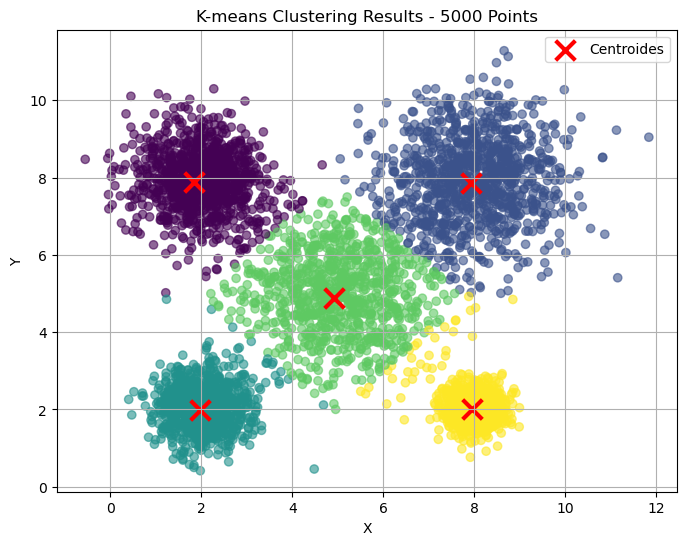

In [17]:
# Executar K-means
centroids, labels = kmeans(data, max_iter=100, k=5)

# Visualizar resultados
plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids['x'], centroids['y'], c='red', marker='x', s=200, linewidths=3, label='Centroides')
plt.title('K-means Clustering Results - 5000 Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

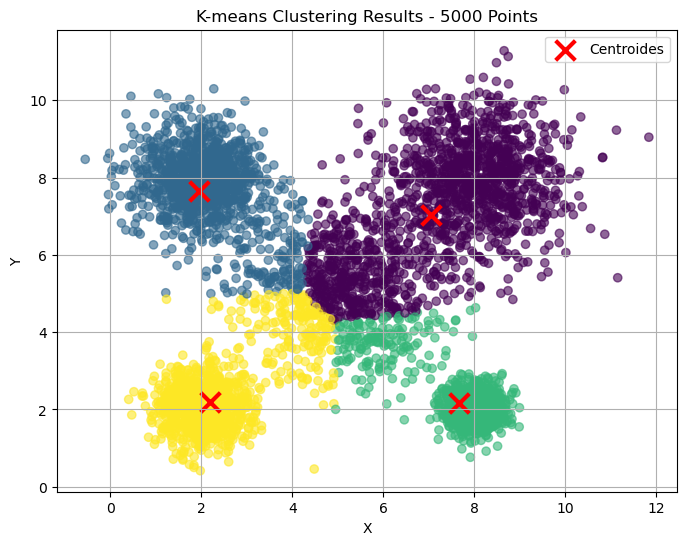

In [18]:
# Executar K-means
centroids, labels = kmeans(data, max_iter=100, k=4)

# Visualizar resultados
plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids['x'], centroids['y'], c='red', marker='x', s=200, linewidths=3, label='Centroides')
plt.title('K-means Clustering Results - 5000 Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

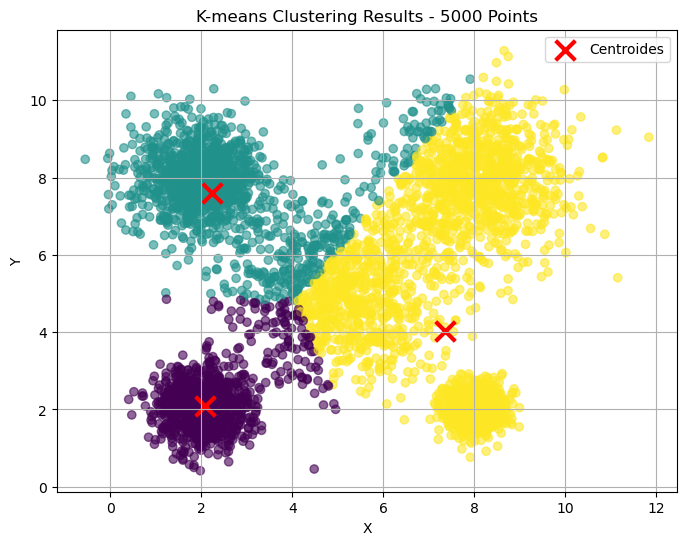

In [19]:
# Executar K-means
centroids, labels = kmeans(data, max_iter=100, k=3)

# Visualizar resultados
plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids['x'], centroids['y'], c='red', marker='x', s=200, linewidths=3, label='Centroides')
plt.title('K-means Clustering Results - 5000 Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

---
<br>

### 3. Tratamento de Erros

In [21]:
def divisao(dividend, divisor):
    """
    Realiza a divisão de dois números, tratando exceções de divisão por zero e entradas inválidas.

    Args:
        dividend: O numerador da divisão (qualquer tipo).
        divisor: O denominador da divisão (qualquer tipo).

    Returns:
        float: O resultado da divisão se bem-sucedida.
        str: Mensagem de erro caso ocorra alguma exceção.
    """
    try:
        # Tenta converter as entradas para float
        dividend = float(dividend)
        divisor = float(divisor)
        
        # Verifica se o divisor é zero
        if divisor == 0:
            return "Erro: Divisão por zero não é permitida."
        
        # Retorna o resultado da divisão
        return dividend / divisor
    except ValueError:
        return "Erro: Entradas inválidas. Certifique-se de fornecer números."
    except Exception as e:
        return f"Erro inesperado: {e}"

#### Teste

In [24]:
resultado = divisao(10, 2)
print(resultado)

erro = divisao(10, 0)
print(erro)  

entrada_invalida = divisao("dez", 2)
print(entrada_invalida)  

5.0
Erro: Divisão por zero não é permitida.
Erro: Entradas inválidas. Certifique-se de fornecer números.
